# Initial setting

In [0]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Mount your drive here by authorizing access
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Building model for randomforest

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [0]:
# Split data into train data and test data
df_model = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/model_dataset.csv')
df = df_model[df_model['year']!=2017]
df_test = df_model[df_model['year']==2017]

In [0]:
# Check the dataset
df_model.head()

,index,num_crimes,year,month,nta_index,NTACode,avg6mon,PopE,MaleP,FemP,hispanicP,whiteP,blackP,asiaP,PopUnder15P,Pop15to34P,Pop35to54P,Pop55to74P,PopOver75P,otherRaceP,employedP,unemployedP,midincome,not_insP,povfamilyP,povchildP,pov65P
0,2013_BK09-1,62,2013,1,2013_BK09,BK09,77.333333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
1,2013_BK09-2,72,2013,2,2013_BK09,BK09,75.166667,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
2,2013_BK09-3,67,2013,3,2013_BK09,BK09,71.833333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
3,2013_BK09-4,72,2013,4,2013_BK09,BK09,69.833333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
4,2013_BK09-5,69,2013,5,2013_BK09,BK09,67.500000,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8


In [0]:
# Drop columns to predict
df.drop(['nta_index','index','year','month','NTACode'], axis=1, inplace=True)
df_test.drop(['nta_index','index','year','month','NTACode'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Transform dataframe to numpy array for building model

In [0]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [0]:
model_RF = RandomForestRegressor()

In [0]:
# grid search
parameter_range = [{'n_estimators': [50, 100, 200],
                    'max_depth' : [5, 10, 50, 100, 200]}]
model = GridSearchCV(model_RF,
                     param_grid = parameter_range,
                     cv = 5,
                     scoring = 'neg_mean_squared_error')
model.fit(X, y)

# best estimator
best_model = model.best_estimator_

In [0]:
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
# Function for plot the results
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

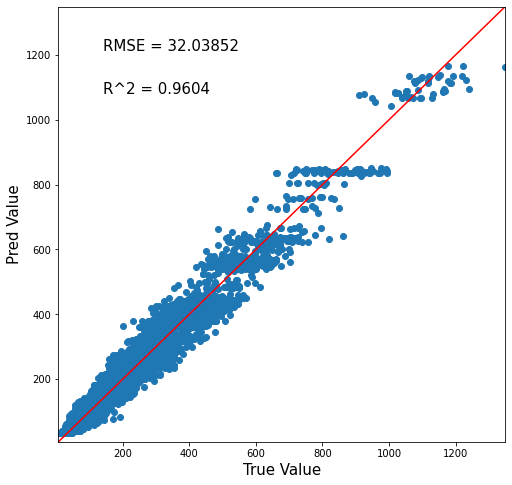

In [0]:
pred_train = best_model.predict(X)
train_y = df['num_crimes'].reset_index()
train_y.drop(columns=['index'],inplace=True)

pred_df_train = pd.concat([train_y, pd.Series(pred_train)], axis=1)
pred_df_train.columns = ['true', 'pred']
True_Pred_map(pred_df_train)

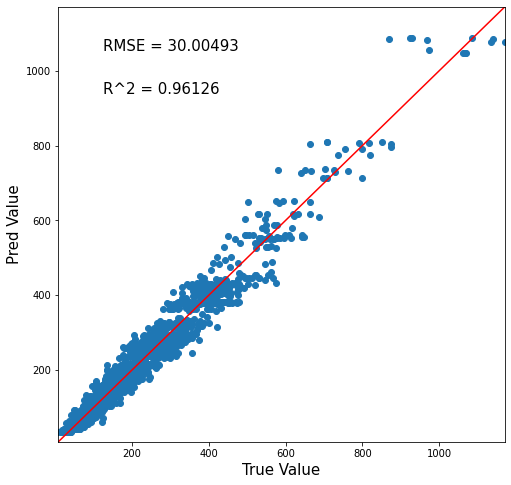

In [0]:
pred = best_model.predict(X_test)
test_y = df_test['num_crimes'].reset_index()
test_y.drop(columns=['index'],inplace=True)

pred_df = pd.concat([test_y, pd.Series(pred)], axis=1)
pred_df.columns = ['true', 'pred']
True_Pred_map(pred_df)

In [0]:
# feature importances
fi = best_model.feature_importances_  
X_train = df.iloc[:, 1:]
fi_df = pd.DataFrame({'feature': list(X_train.columns),
                       'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
fi_df

,feature,feature importance
0,avg6mon,0.975097
1,PopE,0.005922
4,hispanicP,0.003145
9,Pop15to34P,0.003082
8,PopUnder15P,0.002626
16,midincome,0.002228
18,povfamilyP,0.001397
19,povchildP,0.001210
6,blackP,0.001055
15,unemployedP,0.000992


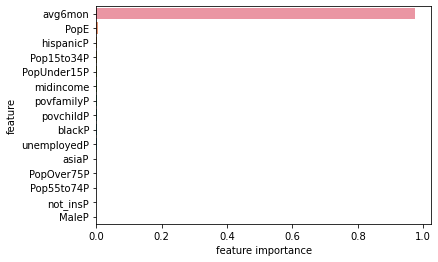

In [0]:
sns_plot = sns.barplot(fi_df['feature importance'][0:15],fi_df['feature'][0:15])
fig = sns_plot.get_figure()

# Using optuna

In [0]:
# Install optuna package
!pip install optuna

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 44.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 112kB 48.7MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=4c22836401974be7ad4eefe8cbf69cdef428659e721e9c49d5a811d29d3b2816
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=766621805da42eebd51a42214ddef83cd67d3ae9b69de3272a9c71144aa2f4f5
  Stored in directory: /root/.cache/pip/wheels/62/f

In [0]:
import optuna
df_model = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/model_dataset.csv')
df = df_model[df_model['year']!=2017]
df_test = df_model[df_model['year']==2017]
df.drop(['nta_index','index','year','month','NTACode'], axis=1, inplace=True)
df_test.drop(['nta_index','index','year','month','NTACode'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
X, y = df.iloc[:,1:], df.iloc[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

# Create objective function
def objective(trial):
  n_estimate = trial.suggest_int('n_estimators', 50, 300, 50)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4, 64, 4)
  max_depth = trial.suggest_int('max_depth', 1, 10, 2)
  RFR = RandomForestRegressor(n_estimators=n_estimate,
                              max_leaf_nodes=max_leaf_nodes, 
                              max_depth=max_depth,
                              random_state = 42)
  RFR.fit(X_train, y_train)
  pred = RFR.predict(X_val)
  return np.sqrt(mean_squared_error(pred, y_val))

In [0]:
# Tuning hyperparaeters
study = optuna.create_study()
study.optimize(objective, n_trials = 50)

[I 2020-04-26 15:05:28,918] Finished trial#0 with value: 137.04274275746042 with parameters: {'n_estimators': 100, 'max_leaf_nodes': 20, 'max_depth': 1}. Best is trial#0 with value: 137.04274275746042.
[I 2020-04-26 15:05:31,084] Finished trial#1 with value: 110.52808347734255 with parameters: {'n_estimators': 150, 'max_leaf_nodes': 4, 'max_depth': 9}. Best is trial#1 with value: 110.52808347734255.
[I 2020-04-26 15:05:32,044] Finished trial#2 with value: 88.30744709389774 with parameters: {'n_estimators': 50, 'max_leaf_nodes': 8, 'max_depth': 5}. Best is trial#2 with value: 88.30744709389774.
[I 2020-04-26 15:05:33,572] Finished trial#3 with value: 90.57509586637151 with parameters: {'n_estimators': 100, 'max_leaf_nodes': 40, 'max_depth': 3}. Best is trial#2 with value: 88.30744709389774.
[I 2020-04-26 15:05:34,960] Finished trial#4 with value: 40.04889751974307 with parameters: {'n_estimators': 50, 'max_leaf_nodes': 44, 'max_depth': 7}. Best is trial#4 with value: 40.04889751974307.


In [0]:
# Confirm the best parameters
study.best_params

{'max_depth': 10, 'max_leaf_nodes': 64, 'n_estimators': 250}

In [0]:
# Confirm the best RMSE
study.best_value

34.426733292377605

In [0]:
# Apply best parameters to the model
model_RF = RandomForestRegressor(max_depth=10,max_leaf_nodes=64, n_estimators=250)

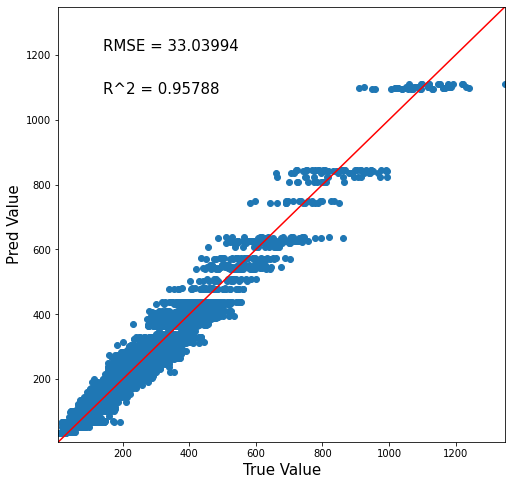

In [0]:
# Apply model to the training data
X = X.values
y = y.values
model_RF.fit(X, y)

pred_train = model_RF.predict(X)
train_y = df['num_crimes'].reset_index()
train_y.drop(columns=['index'],inplace=True)

pred_df_train = pd.concat([train_y, pd.Series(pred_train)], axis=1)
pred_df_train.columns = ['true', 'pred']
True_Pred_map(pred_df_train)
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/RF_train_nonave.png')

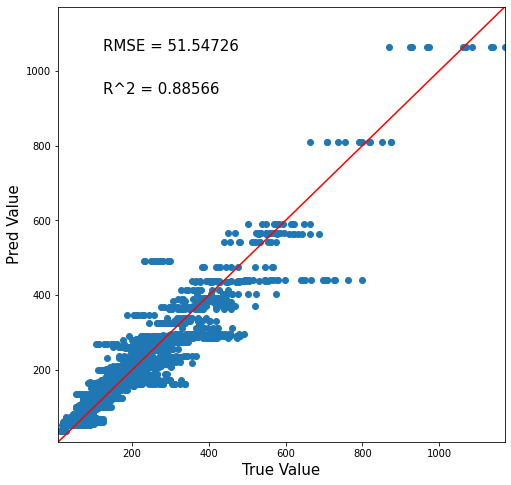

In [0]:
# Apply model to the test data
pred = model_RF.predict(X_test)
test_y = df_test['num_crimes'].reset_index()
test_y.drop(columns=['index'],inplace=True)

pred_df = pd.concat([test_y, pd.Series(pred)], axis=1)
pred_df.columns = ['true', 'pred']
True_Pred_map(pred_df)
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/RF_test_nonave.png')

In [0]:
# feature importances
fi = model_RF.feature_importances_  
X_train = df.iloc[:, 1:]
fi_df = pd.DataFrame({'feature': list(X_train.columns),
                       'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
fi_df

,feature,feature importance
0,PopE,0.403956
15,midincome,0.107270
7,PopUnder15P,0.104861
6,asiaP,0.090725
5,blackP,0.079999
8,Pop15to34P,0.069291
18,povchildP,0.039437
19,pov65P,0.021182
11,PopOver75P,0.012510
4,whiteP,0.011092


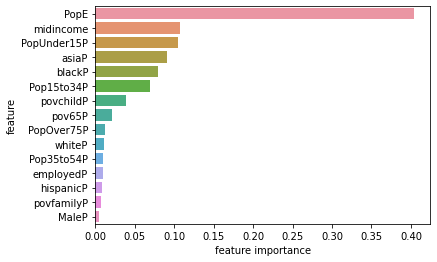

In [0]:
# Plot the feature importance
sns_plot = sns.barplot(fi_df['feature importance'][0:15],fi_df['feature'][0:15])
fig = sns_plot.get_figure()
plt.savefig(r'/content/drive/Shared drives/STATS_507_Fianl_Project/plot_images/RF_features_nonave.png')

# Drop average 6 month

In [0]:
import optuna
df_model = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/model_dataset.csv')
df = df_model[df_model['year']!=2017]
df_test = df_model[df_model['year']==2017]
# drop columns
df.drop(['nta_index','index','year','month','NTACode','avg6mon'], axis=1, inplace=True)
df_test.drop(['nta_index','index','year','month','NTACode','avg6mon'], axis=1, inplace=True)

In [0]:
# To use optuna object, we need to devide train data into two dataset.
X, y = df.iloc[:,1:], df.iloc[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

# Create objective function
def objective(trial):
  n_estimate = trial.suggest_int('n_estimators', 50, 300, 50)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4, 64, 4)
  max_depth = trial.suggest_int('max_depth', 1, 10, 2)
  RFR = RandomForestRegressor(n_estimators=n_estimate,
                              max_leaf_nodes=max_leaf_nodes, 
                              max_depth=max_depth,
                              random_state = 42)
  RFR.fit(X_train, y_train)
  pred = RFR.predict(X_val)
  return np.sqrt(mean_squared_error(pred, y_val))

In [0]:
# Tuning hyperparaeters
study = optuna.create_study()
study.optimize(objective, n_trials = 50)

In [0]:
# confirm the best parameters
study.best_params

In [0]:
# confirm the best RMSE
study.best_value

In [0]:
# Apply best parameters to the model
model_RF = RandomForestRegressor(max_depth=10,max_leaf_nodes=64, n_estimators=250)